In [2]:
Features = pd.read_csv('/kaggle/input/test-1/features_emotion_final.csv')

In [2]:


import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# MLP

In [4]:
dataset_path = '/kaggle/input/test-4/features_age_emotion.csv'

data = pd.read_csv(dataset_path)

In [5]:
data['age'] = pd.cut(data['age'], bins=[20, 29, 39, 49, 59, 69, 79],
                           labels=['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies'],
                           right=False)

In [6]:
data = data.fillna(0)

In [7]:
data['gender'] = data['gender'].replace("female",0)
data['gender'] = data['gender'].replace("male",1)

In [8]:
encoded_df = pd.get_dummies(data['emotion'])
df_encoded = pd.concat([data, encoded_df], axis=1)
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,2859,age,gender,emotion,anger,anxiety/fear,disgust,happiness,neutral,sadness
0,0.017090,0.024902,0.028809,0.045410,0.074707,0.100098,0.119141,0.110840,0.088867,0.067383,...,0.0,fifties,1,anger,1,0,0,0,0,0
1,0.182129,0.256836,0.350098,0.351074,0.281738,0.240234,0.170410,0.110840,0.089844,0.068359,...,0.0,fifties,1,anger,1,0,0,0,0,0
2,0.015625,0.029297,0.070801,0.104004,0.132324,0.149414,0.131836,0.109863,0.092773,0.076660,...,0.0,fifties,1,anger,1,0,0,0,0,0
3,0.076660,0.113770,0.167969,0.180176,0.173340,0.166992,0.136719,0.109863,0.091309,0.075684,...,0.0,fifties,1,anger,1,0,0,0,0,0
4,0.015137,0.031738,0.036621,0.041504,0.037109,0.026855,0.029297,0.029297,0.035645,0.067383,...,0.0,fifties,1,disgust,0,0,1,0,0,0


In [9]:
encoded_df = pd.get_dummies(data['age'])
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,disgust,happiness,neutral,sadness,twenties,thirties,forties,fifties,sixties,seventies
0,0.017090,0.024902,0.028809,0.045410,0.074707,0.100098,0.119141,0.110840,0.088867,0.067383,...,0,0,0,0,0,0,0,1,0,0
1,0.182129,0.256836,0.350098,0.351074,0.281738,0.240234,0.170410,0.110840,0.089844,0.068359,...,0,0,0,0,0,0,0,1,0,0
2,0.015625,0.029297,0.070801,0.104004,0.132324,0.149414,0.131836,0.109863,0.092773,0.076660,...,0,0,0,0,0,0,0,1,0,0
3,0.076660,0.113770,0.167969,0.180176,0.173340,0.166992,0.136719,0.109863,0.091309,0.075684,...,0,0,0,0,0,0,0,1,0,0
4,0.015137,0.031738,0.036621,0.041504,0.037109,0.026855,0.029297,0.029297,0.035645,0.067383,...,1,0,0,0,0,0,0,1,0,0


In [10]:
df_encoded.drop(['age','emotion'],axis=1,inplace=True)


In [11]:
df_encoded.iloc[:,2860:].head()


,gender,anger,anxiety/fear,disgust,happiness,neutral,sadness,twenties,thirties,forties,fifties,sixties,seventies
0,1,1,0,0,0,0,0,0,0,0,1,0,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0
2,1,1,0,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,1,0,0


In [12]:
X = df_encoded.drop(['gender', 'anger', 'anxiety/fear', 'disgust', 'happiness', 'neutral', 'sadness','twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies'], axis=1).values


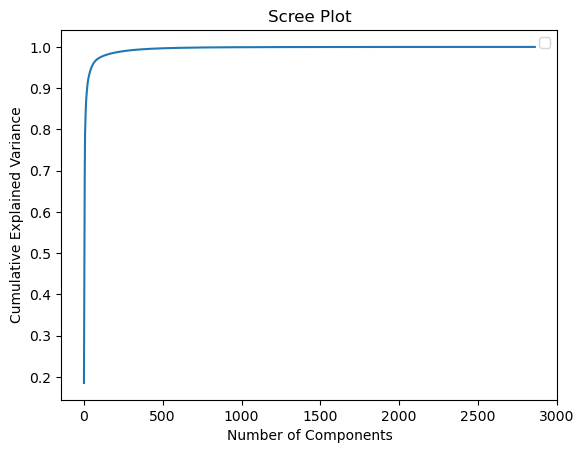

In [14]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Scree plot
num_components = len(explained_variance_ratio)

plt.plot(range(1, num_components + 1), np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')

plt.legend()
plt.show()

In [15]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Choose the desired level of explained variance
X_reduced = pca.fit_transform(X)

# Print the shape of the reduced feature matrix
print(f"Shape of the reduced feature matrix: {X_reduced.shape}")

Shape of the reduced feature matrix: (31584, 100)


In [16]:
y = df_encoded[['anger', 'anxiety/fear', 'disgust', 'happiness', 'neutral', 'sadness']].values


In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X_reduced, y, test_size=0.3, random_state=30,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp)


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from keras.optimizers import SGD

In [41]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer = Dense(2048, activation='relu')(input_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.25)(hidden_layer)
hidden_layer = Dense(1024, activation='relu')(hidden_layer)
hidden_layer = Dense(512, activation='relu')(hidden_layer)
hidden_layer = Dense(64, activation='relu')(hidden_layer)


In [42]:
emotion_output = Dense(y_train.shape[1], activation='softmax', name='emotion')(hidden_layer)


In [43]:
model = Model(inputs=input_layer, outputs=[emotion_output])


In [44]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_8 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                           

In [48]:
opt = SGD(learning_rate=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
              loss={
                    'emotion': 'categorical_crossentropy',
                    },
              metrics={
                       'emotion': 'accuracy',
                       })

In [49]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, start_from_epoch=20)


In [50]:
history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=300, batch_size=32, callbacks=early_stop)

Epoch 1/200
691/691 [==============================] - 4s 5ms/step - loss: 1.6153 - accuracy: 0.3326 - val_loss: 1.5104 - val_accuracy: 0.3795
Epoch 2/200
691/691 [==============================] - 3s 5ms/step - loss: 1.5237 - accuracy: 0.3744 - val_loss: 1.4705 - val_accuracy: 0.3964
Epoch 3/200
691/691 [==============================] - 3s 5ms/step - loss: 1.4831 - accuracy: 0.3910 - val_loss: 1.4354 - val_accuracy: 0.4198
Epoch 4/200
691/691 [==============================] - 3s 4ms/step - loss: 1.4562 - accuracy: 0.4018 - val_loss: 1.4229 - val_accuracy: 0.4179
Epoch 5/200
691/691 [==============================] - 3s 4ms/step - loss: 1.4393 - accuracy: 0.4113 - val_loss: 1.4098 - val_accuracy: 0.4255
Epoch 6/200
691/691 [==============================] - 3s 4ms/step - loss: 1.4226 - accuracy: 0.4170 - val_loss: 1.3987 - val_accuracy: 0.4272
Epoch 7/200
691/691 [==============================] - 3s 4ms/step - loss: 1.4063 - accuracy: 0.4274 - val_loss: 1.3848 - val_accuracy: 0.4379

In [51]:
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

149/149 [==============================] - 0s 2ms/step


In [59]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 0s 3ms/step - loss: 0.3079 - accuracy: 0.9147
Accuracy of our model on test data :  91.47319793701172 %


In [56]:
pred_test = model.predict(X_test)


149/149 [==============================] - 0s 2ms/step


In [60]:
pred_test.shape

(4738, 6)

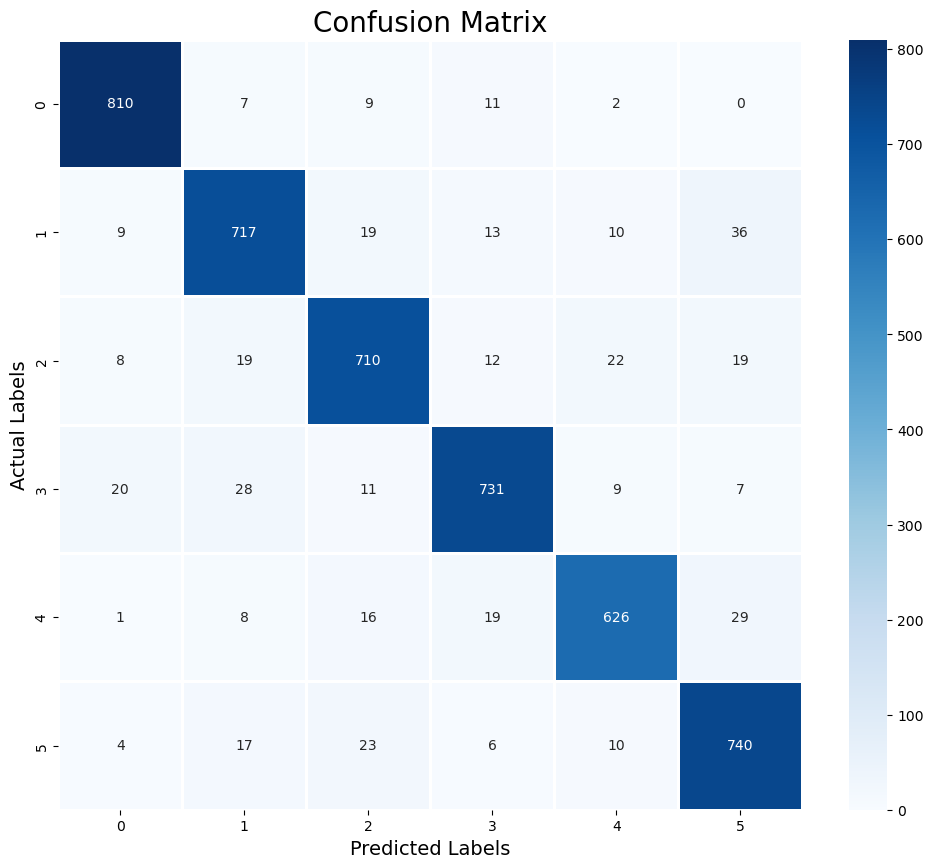

In [63]:
cm = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [61]:
print(classification_report(y_test.argmax(axis=1) , y_pred.argmax(axis=1), target_names=['anger', 'anxiety/fear', 'disgust', 'happiness', 'neutral', 'sad']))

              precision    recall  f1-score   support

       anger       0.95      0.97      0.96       839
anxiety/fear       0.90      0.89      0.90       804
     disgust       0.90      0.90      0.90       790
   happiness       0.92      0.91      0.91       806
     neutral       0.92      0.90      0.91       699
         sad       0.89      0.93      0.91       800

    accuracy                           0.91      4738
   macro avg       0.91      0.91      0.91      4738
weighted avg       0.91      0.91      0.91      4738



## From voice features and predicted emotion, predict gender

In [65]:
Z = model.predict(X_reduced)

987/987 [==============================] - 2s 2ms/step


In [67]:
Z = pd.DataFrame(Z)

In [69]:
temp = pd.DataFrame(X_reduced)

In [72]:
X_reduced2 = pd.concat([temp, Z], axis=1)

In [73]:
y = df_encoded['gender'].values


In [96]:
temp1 = pd.get_dummies(data['gender'])
temp2 = pd.DataFrame(temp1)
temp2.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [97]:
y = temp2.values

In [74]:
X_reduced2 = X_reduced2.values

In [98]:
X_train, X_temp, y_train, y_temp = train_test_split(X_reduced2, y, test_size=0.3, random_state=30,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp)


In [99]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from keras.optimizers import SGD

In [100]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer = Dense(2048, activation='relu')(input_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.25)(hidden_layer)
hidden_layer = Dense(1024, activation='relu')(hidden_layer)
hidden_layer = Dense(512, activation='relu')(hidden_layer)
hidden_layer = Dense(64, activation='relu')(hidden_layer)


In [101]:
y_train.shape

(22108, 2)

In [104]:
gender_output = Dense(2, activation='softmax', name='gender')(hidden_layer)

In [105]:
model2 = Model(inputs=input_layer, outputs=[gender_output])


In [106]:
opt = SGD(learning_rate=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer=opt,
              loss={
                    'gender': 'binary_crossentropy',
                    },
              metrics={
                       'gender': 'accuracy',
                       })

In [107]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, start_from_epoch=20)

In [108]:
model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 106)]             0         
                                                                 
 dense_16 (Dense)            (None, 2048)              219136    
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                           

In [109]:
history2 = model2.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=300, batch_size=32, callbacks=early_stop)

Epoch 1/300
691/691 [==============================] - 4s 4ms/step - loss: 0.7037 - accuracy: 0.5424 - val_loss: 0.6768 - val_accuracy: 0.5756
Epoch 2/300
691/691 [==============================] - 3s 4ms/step - loss: 0.6801 - accuracy: 0.5740 - val_loss: 0.6638 - val_accuracy: 0.5973
Epoch 3/300
691/691 [==============================] - 3s 5ms/step - loss: 0.6680 - accuracy: 0.5963 - val_loss: 0.6543 - val_accuracy: 0.6089
Epoch 4/300
691/691 [==============================] - 3s 4ms/step - loss: 0.6588 - accuracy: 0.6046 - val_loss: 0.6444 - val_accuracy: 0.6313
Epoch 5/300
691/691 [==============================] - 3s 4ms/step - loss: 0.6468 - accuracy: 0.6200 - val_loss: 0.6418 - val_accuracy: 0.6294
Epoch 6/300
691/691 [==============================] - 3s 4ms/step - loss: 0.6333 - accuracy: 0.6403 - val_loss: 0.6149 - val_accuracy: 0.6688
Epoch 7/300
691/691 [==============================] - 3s 4ms/step - loss: 0.6224 - accuracy: 0.6500 - val_loss: 0.6222 - val_accuracy: 0.6494

In [110]:
print("Accuracy of our model on test data : " , model2.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 0s 2ms/step - loss: 0.2345 - accuracy: 0.9040
Accuracy of our model on test data :  90.39679169654846 %


In [112]:
pred_test = model2.predict(X_test)


149/149 [==============================] - 0s 2ms/step


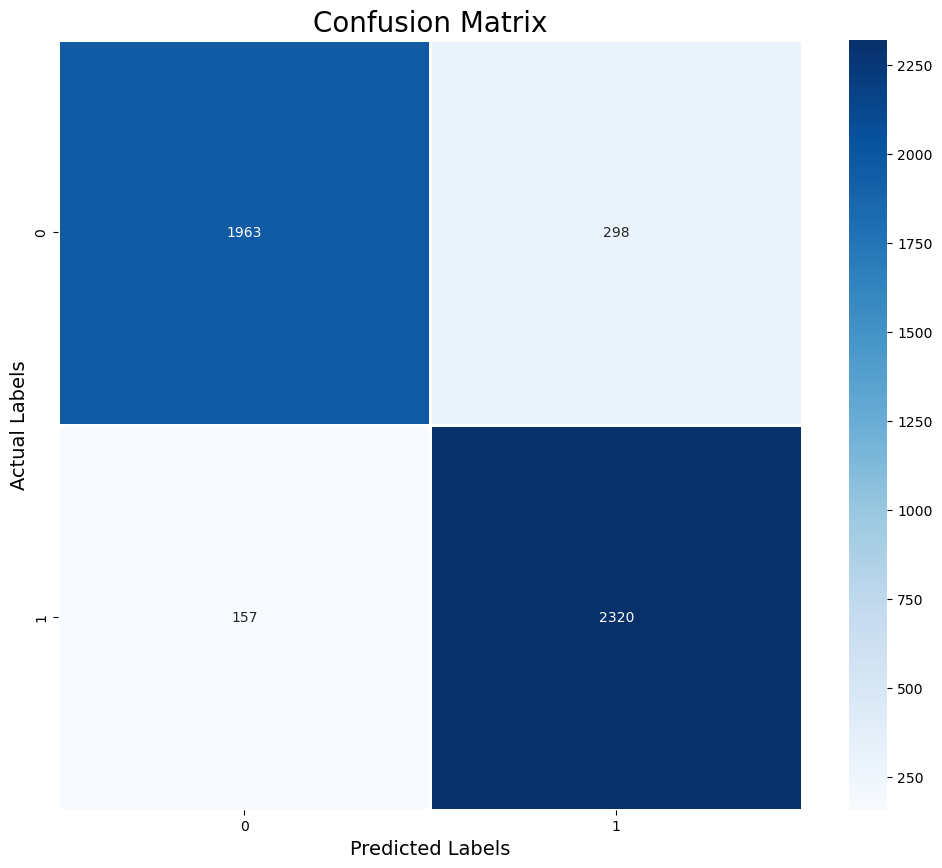

In [114]:
cm = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [116]:
print(classification_report(y_test.argmax(axis=1) , pred_test.argmax(axis=1), target_names=['male','female']))

              precision    recall  f1-score   support

        male       0.93      0.87      0.90      2261
      female       0.89      0.94      0.91      2477

    accuracy                           0.90      4738
   macro avg       0.91      0.90      0.90      4738
weighted avg       0.91      0.90      0.90      4738



## From voice features and predicted gender, predict Age

In [118]:
Z = model2.predict(X_reduced2)

987/987 [==============================] - 2s 2ms/step


In [119]:
temp = pd.DataFrame(X_reduced)

In [121]:
Z = pd.DataFrame(Z)

In [122]:
X_reduced3 = pd.concat([temp, Z], axis=1)

In [123]:
temp1 = pd.get_dummies(data['age'])
temp2 = pd.DataFrame(temp1)
temp2.head()

,twenties,thirties,forties,fifties,sixties,seventies
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [124]:
y = temp2.values

In [125]:
X_reduced3 = X_reduced3.values

In [126]:
X_train, X_temp, y_train, y_temp = train_test_split(X_reduced3, y, test_size=0.3, random_state=30,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp)

In [127]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from keras.optimizers import SGD

In [128]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer = Dense(2048, activation='relu')(input_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.25)(hidden_layer)
hidden_layer = Dense(1024, activation='relu')(hidden_layer)
hidden_layer = Dense(512, activation='relu')(hidden_layer)
hidden_layer = Dense(64, activation='relu')(hidden_layer)


In [129]:
age_output = Dense(6, activation='softmax', name='age')(hidden_layer)

In [130]:
model3 = Model(inputs=input_layer, outputs=[age_output])


In [136]:
opt = SGD(learning_rate=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(optimizer=opt,
              loss={
                    'age': 'categorical_crossentropy',
                    },
              metrics={
                       'age': 'accuracy',
                       })

In [137]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, start_from_epoch=20)

In [138]:
history3 = model3.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=300, batch_size=32, callbacks=early_stop)

Epoch 1/300
691/691 [==============================] - 4s 5ms/step - loss: 1.5291 - accuracy: 0.3427 - val_loss: 1.4859 - val_accuracy: 0.3624
Epoch 2/300
691/691 [==============================] - 3s 4ms/step - loss: 1.4728 - accuracy: 0.3651 - val_loss: 1.4678 - val_accuracy: 0.3594
Epoch 3/300
691/691 [==============================] - 3s 4ms/step - loss: 1.4573 - accuracy: 0.3719 - val_loss: 1.4662 - val_accuracy: 0.3637
Epoch 4/300
691/691 [==============================] - 3s 4ms/step - loss: 1.4477 - accuracy: 0.3775 - val_loss: 1.4513 - val_accuracy: 0.3755
Epoch 5/300
691/691 [==============================] - 3s 4ms/step - loss: 1.4386 - accuracy: 0.3824 - val_loss: 1.4491 - val_accuracy: 0.3660
Epoch 6/300
691/691 [==============================] - 3s 4ms/step - loss: 1.4309 - accuracy: 0.3788 - val_loss: 1.4419 - val_accuracy: 0.3759
Epoch 7/300
691/691 [==============================] - 3s 4ms/step - loss: 1.4204 - accuracy: 0.3902 - val_loss: 1.4372 - val_accuracy: 0.3753

In [139]:
print("Accuracy of our model on test data : " , model3.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 0s 3ms/step - loss: 0.3814 - accuracy: 0.9179
Accuracy of our model on test data :  91.78978204727173 %


In [140]:
pred_test = model3.predict(X_test)

149/149 [==============================] - 0s 2ms/step


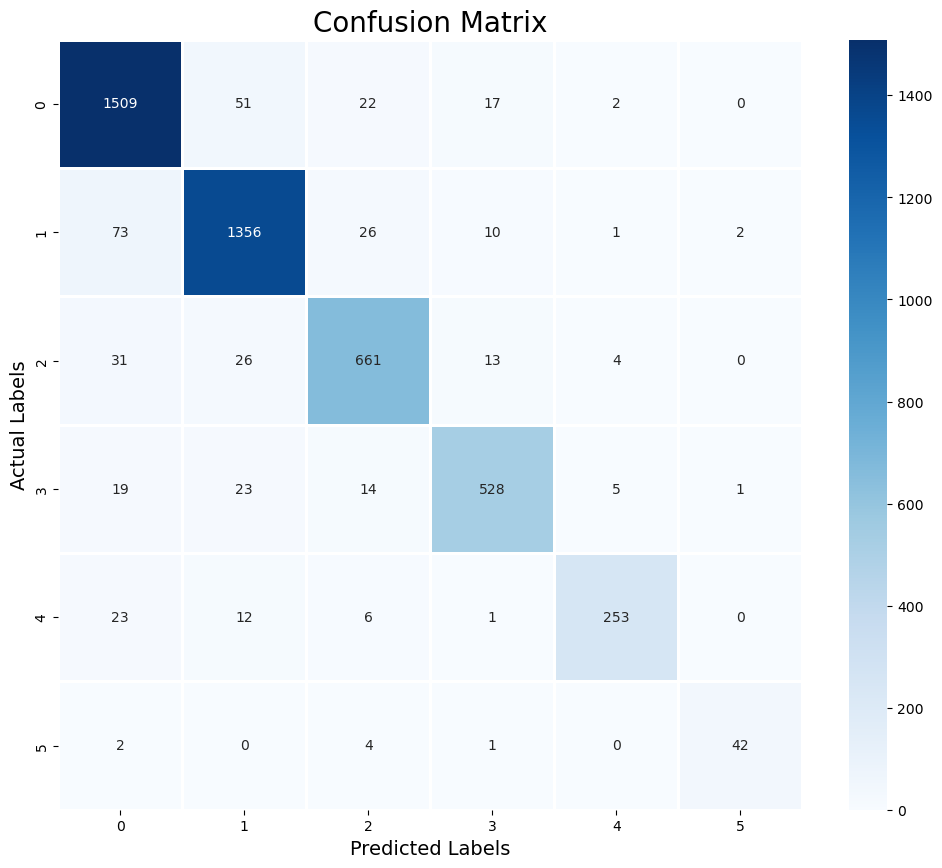

In [141]:
cm = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [142]:
print(classification_report(y_test.argmax(axis=1) , pred_test.argmax(axis=1), target_names=['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies']))

              precision    recall  f1-score   support

    twenties       0.91      0.94      0.93      1601
    thirties       0.92      0.92      0.92      1468
     forties       0.90      0.90      0.90       735
     fifties       0.93      0.89      0.91       590
     sixties       0.95      0.86      0.90       295
   seventies       0.93      0.86      0.89        49

    accuracy                           0.92      4738
   macro avg       0.93      0.90      0.91      4738
weighted avg       0.92      0.92      0.92      4738

